# Camera Calibration

In [42]:
import numpy as np
import cv2
import matplotlib.lines as lines
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Camera Calibration Function Build

In [15]:
import glob
images = glob.glob('../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')

objpoints = []
imgpoints = []


objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

counter = 0
idx = 1
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
    
    
    if ret == True:
        counter += 1 
        imgpoints.append(corners)
        objpoints.append(objp)
    else:
        print('Chessboard corner detection failed:', fname)

#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#dst = cv2.undistort(img, mtx, dist, None, mtx)

def cal_undistort(img, objpoints, imgpoints):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist  = cv2.undistort(img,mtx,dist,None,mtx)
    
    return undist

Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg
Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration5.jpg
Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration4.jpg


### Camera Calibration Function Test
Test Function on three Uncompleted picture

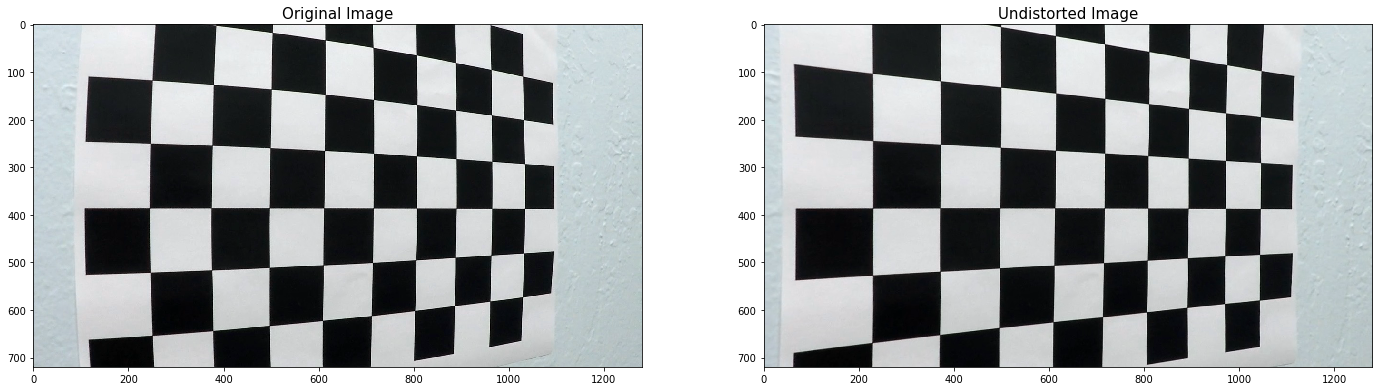

In [16]:
img = cv2.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration5.jpg')

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=15)

## Pipeline

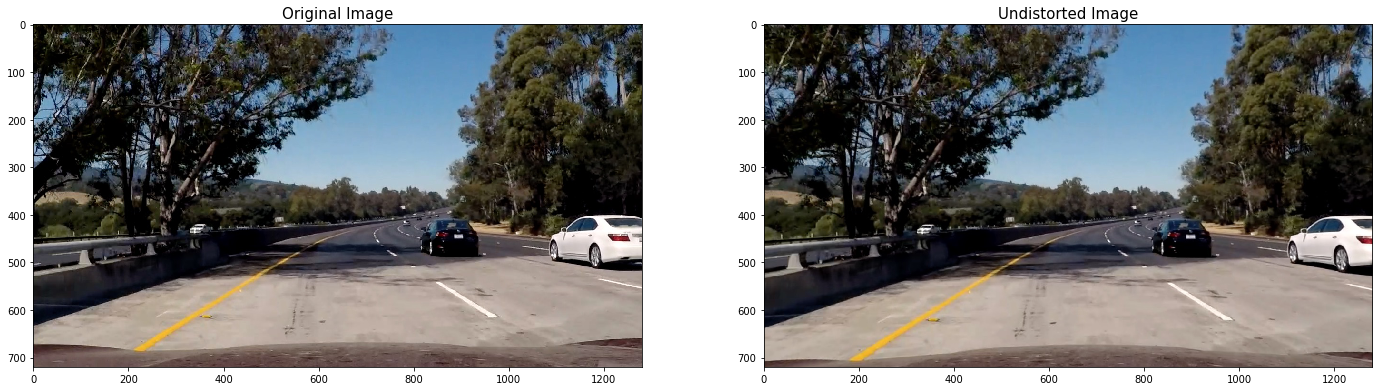

In [127]:
img = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/test5.jpg')
undist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=15)

## Pipeline

## Color and Gradients
color transforms, gradients or other methods to create a thresholded binary image. 

#### HLS,Color Space

In [71]:
def HLS_thresh(img, orient='S', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    if orient == 'H':
        Channel = hls[:,:,0]
    if orient == 'L':
        Channel = hls[:,:,1]
    if orient == 'S':
        Channel = hls[:,:,2]

    binary = np.zeros_like(Channel)
    binary[(Channel >= thresh[0]) & (Channel <= thresh[1])] = 1
    
    return binary

In [72]:
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


#### Theshold Function verification

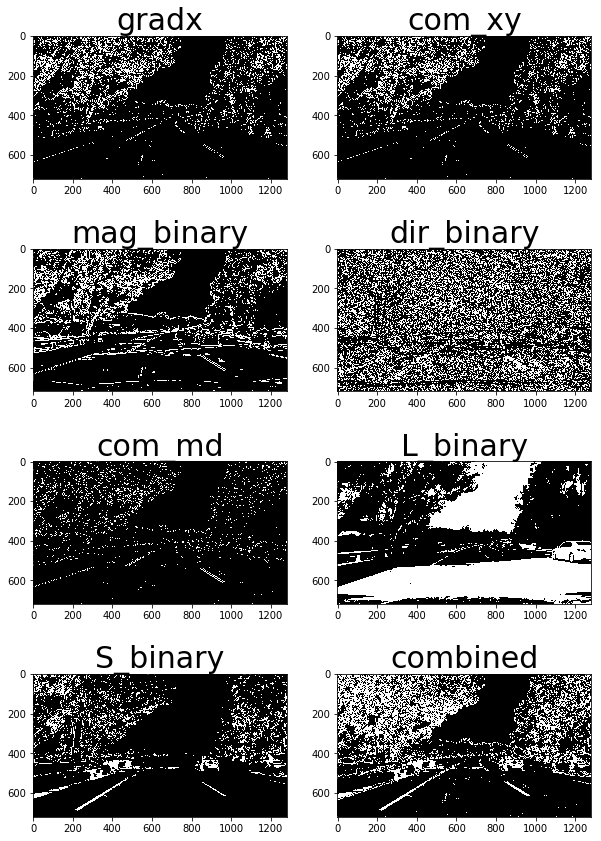

In [177]:
image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/test5.jpg')
# output = img_gradient(img, sobel_kernel=3, x_thresh=(20, 100), y_thresh=(0, 255), mag_thresh=(30, 100), dir_thresh=(0.7, 1.3))
#image = undistorted
# BLACK is 0, White is 1

gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(0, 255))
mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
H_binary = HLS_thresh(image, orient='H', thresh=(100, 255))
L_binary = HLS_thresh(image, orient='L', thresh=(100, 255))
S_binary = HLS_thresh(image, orient='S', thresh=(140, 255))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) |(S_binary == 1)] = 1
com_xy = np.zeros_like(dir_binary)
com_xy[(gradx == 1) & (grady == 1)] = 1

com_md = np.zeros_like(dir_binary)
com_md[((mag_binary == 1) & (dir_binary == 1))] = 1


f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(10, 15))
#f, (ax5, ax6, ax7, ax8) = plt.subplots(-1, 2, figsize=(24, 9))
ax1.imshow(gradx,'gray')
ax1.set_title('gradx', fontsize=30)

ax2.imshow(com_xy,cmap='gray')
ax2.set_title('com_xy', fontsize=30)

ax3.imshow(mag_binary,'gray')
ax3.set_title('mag_binary', fontsize=30)

ax4.imshow(dir_binary,cmap='gray')
ax4.set_title('dir_binary', fontsize=30)

ax5.imshow(com_md,'gray')
ax5.set_title('com_md', fontsize=30)

ax6.imshow(L_binary,cmap='gray')
ax6.set_title('L_binary', fontsize=30)

ax7.imshow(S_binary,cmap='gray')
ax7.set_title('S_binary', fontsize=30)

ax8.imshow(combined,cmap='gray')
ax8.set_title('combined', fontsize=30)

## Perspective Transform

In [179]:
image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg')
#plt.imshow(image)
plt.show()

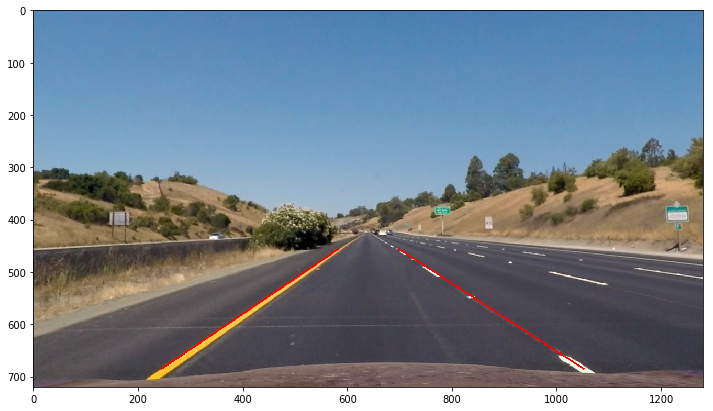

In [180]:
undist = cal_undistort(image, objpoints, imgpoints)
gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
img_size = gray.shape[::-1]

"""
plt.imshow(undist)
plt.plot(245,685,'.')
plt.plot(1052,685,'.')
plt.plot(699,456,'.')
plt.plot(575,456,'.')
"""

cv2.line(undist,(1052,685),(699,456),(255,0,0),thickness=2)
cv2.line(undist,(245,685),(583,456),(255,0,0),thickness=2)
#lines.Line2D((1052,699),(685,456),linewidth=4, color='r')

#plt.axhline(ymax = 865,ymin= 456, xmin=699, xmax=1052,linewidth=4, color='r')

plt.figure(figsize=(12, 12))
plt.imshow(undist)

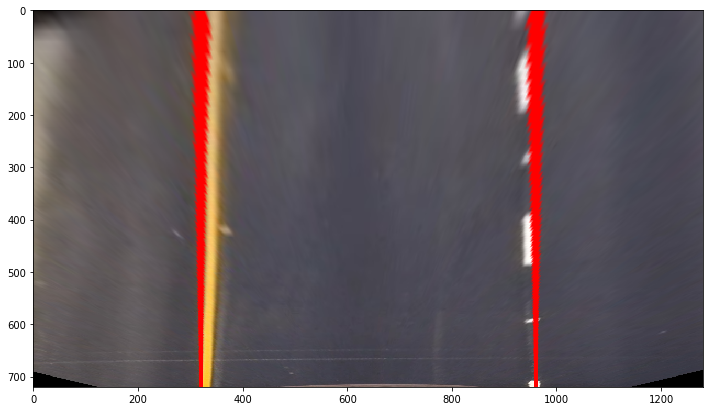

In [181]:
A = [245,685]
B = [1052,685]
C = [699,456]
D = [583,456]
src = np.float32([D,A,B,C])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

cv2.line(warped,(int(img_size[0] * 3 / 4),img_size[1]),(int(img_size[0] * 3 / 4),0),(255,0,0),thickness=5)
cv2.line(warped,(int(img_size[0] / 4),img_size[1]),(int(img_size[0] / 4),0),(255,0,0),thickness=5)

plt.figure(figsize=(12, 12))
plt.imshow(warped)

## Find Lane Line

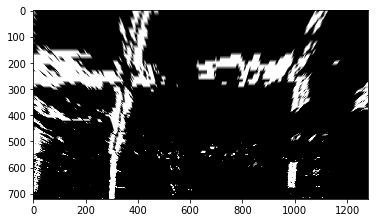

In [129]:
binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped,cmap = 'gray')

(720, 1280)
(1280,)


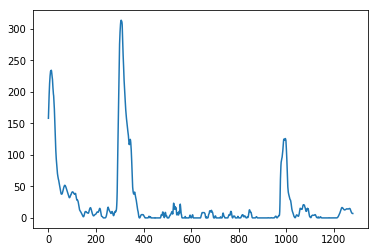

In [130]:
print(binary_warped.shape)
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
print(histogram.shape)
plt.plot(histogram)


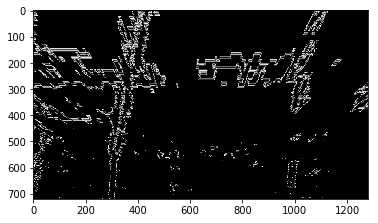

In [131]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

plt.imshow(out_img,cmap = 'gray')

In [137]:
def fit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    #plt.imshow(out_img,cmap = 'gray')
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit,right_fit,ploty

(720, 0)

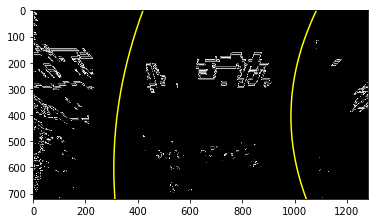

In [132]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [91]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

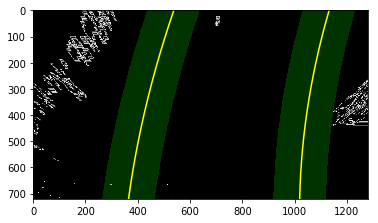

In [102]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

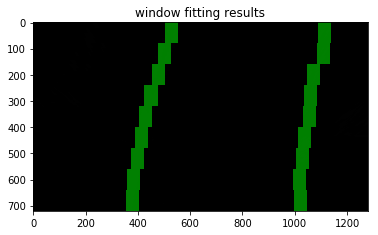

In [93]:
# Read in a thresholded image
warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [95]:
print(left_fit)
print(right_fit)

[  1.30302888e-04  -3.36482829e-01   5.37361802e+02]
[  1.70870169e-04  -2.82347816e-01   1.13107927e+03]


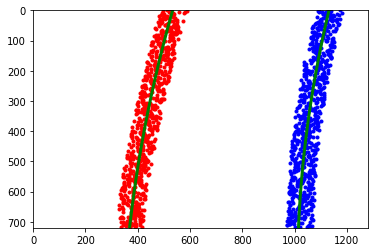

In [107]:
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

leftx = np.array([left_fit[0]*y**2 + left_fit[1]*y + left_fit[2] + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([right_fit[0]*y**2 + right_fit[1]*y + right_fit[2] + np.random.randint(-50, high=51) 
                                for y in ploty])

# leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
# rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

## Measuring Curvature and Position

In [108]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

3710.8714514 3193.52958321


In [109]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

1189.37485976 m 1045.20600737 m


### Verification of Measuring Curvature and Position

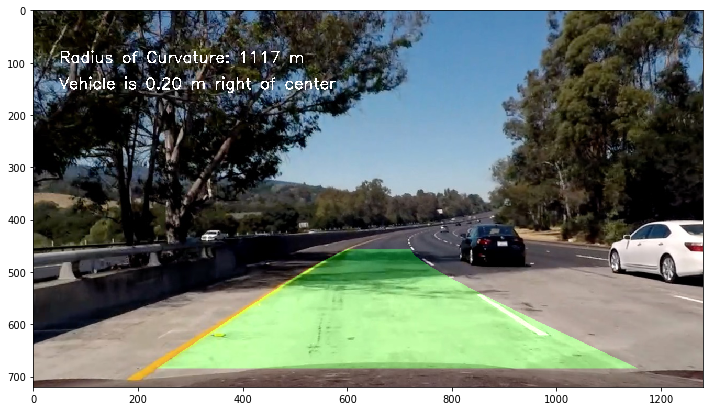

In [174]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

curvature = (left_curverad+right_curverad)/2

font = cv2.FONT_HERSHEY_SIMPLEX
text = "Radius of Curvature: {} m".format(int(curvature))
cv2.putText(result,text,(50,100), font, 1,(255,255,255),2)

py = binary_warped.shape[0]-1
left_x = left_fit[0]*py**2 + left_fit[1]*py + left_fit[2]
right_x = right_fit[0]*py**2 + right_fit[1]*py + right_fit[2]
position = ((left_x+right_x-binary_warped.shape[1])/2)*(3.7/700)

if position < 0:
    text = "Vehicle is {:.2f} m left of center".format(-position)
else:
    text = "Vehicle is {:.2f} m right of center".format(position)
cv2.putText(result,text,(50,150), font, 1,(255,255,255),2)


plt.figure(figsize=(12,12))
plt.imshow(result)

## Video Processing

In [134]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [169]:
def process_image(image):
    undist = cal_undistort(image, objpoints, imgpoints)
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(0, 255))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    H_binary = HLS_thresh(image, orient='H', thresh=(100, 255))
    L_binary = HLS_thresh(image, orient='L', thresh=(100, 255))
    S_binary = HLS_thresh(image, orient='S', thresh=(140, 255))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) |(S_binary == 1)] = 1
    
    binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(binary_warped,cmap = 'gray')
    
    left_fit,right_fit, ploty = fit(binary_warped)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx = np.array([left_fit[0]*y**2 + left_fit[1]*y + left_fit[2] + np.random.randint(-50, high=51) 
                              for y in ploty])
    rightx = np.array([right_fit[0]*y**2 + right_fit[1]*y + right_fit[2] + np.random.randint(-50, high=51) 
                                for y in ploty])
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    curvature = (left_curverad+right_curverad)/2

    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(result,text,(50,100), font, 1,(255,255,255),2)
    
    py = binary_warped.shape[0]-1
    left_x = left_fit[0]*py**2 + left_fit[1]*py + left_fit[2]
    right_x = right_fit[0]*py**2 + right_fit[1]*py + right_fit[2]
    position = ((left_x+right_x-binary_warped.shape[1])/2)*(3.7/700)
    
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result,text,(50,150), font, 1,(255,255,255),2)
    
    
    return result

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:01<25:51,  1.23s/it]


  0%|          | 2/1261 [00:02<25:20,  1.21s/it]


  0%|          | 3/1261 [00:03<23:18,  1.11s/it]


  0%|          | 4/1261 [00:04<22:40,  1.08s/it]


  0%|          | 5/1261 [00:05<21:24,  1.02s/it]


  0%|          | 6/1261 [00:06<22:52,  1.09s/it]


  1%|          | 7/1261 [00:07<22:36,  1.08s/it]


  1%|          | 8/1261 [00:08<22:03,  1.06s/it]


  1%|          | 9/1261 [00:09<22:15,  1.07s/it]


  1%|          | 10/1261 [00:10<20:56,  1.00s/it]


  1%|          | 11/1261 [00:11<20:07,  1.03it/s]


  1%|          | 12/1261 [00:12<19:39,  1.06it/s]


  1%|          | 13/1261 [00:13<20:42,  1.00it/s]


  1%|          | 14/1261 [00:14<20:57,  1.01s/it]


  1%|          | 15/1261 [00:15<20:13,  1.03it/s]


  1%|▏         | 16/1261 [00:16<19:38,  1.06it/s]


  1%|▏         | 17/1261 [00:17<19:36,  1.06it/s]


  1%|▏         | 18/1261 [00:18<20:51,  1.01s/it]


  2%|▏         | 19/1261 [0

 11%|█         | 134/1261 [02:19<20:33,  1.09s/it]


 11%|█         | 135/1261 [02:20<21:08,  1.13s/it]


 11%|█         | 136/1261 [02:21<21:56,  1.17s/it]


 11%|█         | 137/1261 [02:22<21:31,  1.15s/it]


 11%|█         | 138/1261 [02:23<22:26,  1.20s/it]


 11%|█         | 139/1261 [02:25<21:35,  1.15s/it]


 11%|█         | 140/1261 [02:26<21:06,  1.13s/it]


 11%|█         | 141/1261 [02:27<20:58,  1.12s/it]


 11%|█▏        | 142/1261 [02:28<21:13,  1.14s/it]


 11%|█▏        | 143/1261 [02:29<20:48,  1.12s/it]


 11%|█▏        | 144/1261 [02:30<21:41,  1.16s/it]


 11%|█▏        | 145/1261 [02:31<20:50,  1.12s/it]


 12%|█▏        | 146/1261 [02:32<19:19,  1.04s/it]


 12%|█▏        | 147/1261 [02:33<18:09,  1.02it/s]


 12%|█▏        | 148/1261 [02:34<18:13,  1.02it/s]


 12%|█▏        | 149/1261 [02:35<18:42,  1.01s/it]


 12%|█▏        | 150/1261 [02:36<17:45,  1.04it/s]


 12%|█▏        | 151/1261 [02:37<17:12,  1.08it/s]


 12%|█▏        | 152/1261 [02:38<17:34,  1.05i

 21%|██        | 266/1261 [04:36<16:55,  1.02s/it]


 21%|██        | 267/1261 [04:37<17:12,  1.04s/it]


 21%|██▏       | 268/1261 [04:38<16:21,  1.01it/s]


 21%|██▏       | 269/1261 [04:39<17:24,  1.05s/it]


 21%|██▏       | 270/1261 [04:40<18:48,  1.14s/it]


 21%|██▏       | 271/1261 [04:42<18:25,  1.12s/it]


 22%|██▏       | 272/1261 [04:43<18:35,  1.13s/it]


 22%|██▏       | 273/1261 [04:44<18:06,  1.10s/it]


 22%|██▏       | 274/1261 [04:45<18:11,  1.11s/it]


 22%|██▏       | 275/1261 [04:46<18:34,  1.13s/it]


 22%|██▏       | 276/1261 [04:47<17:21,  1.06s/it]


 22%|██▏       | 277/1261 [04:48<17:09,  1.05s/it]


 22%|██▏       | 278/1261 [04:49<16:17,  1.01it/s]


 22%|██▏       | 279/1261 [04:50<16:33,  1.01s/it]


 22%|██▏       | 280/1261 [04:51<16:35,  1.01s/it]


 22%|██▏       | 281/1261 [04:52<17:14,  1.06s/it]


 22%|██▏       | 282/1261 [04:53<16:46,  1.03s/it]


 22%|██▏       | 283/1261 [04:54<16:47,  1.03s/it]


 23%|██▎       | 284/1261 [04:55<17:16,  1.06s

 32%|███▏      | 398/1261 [06:52<14:54,  1.04s/it]


 32%|███▏      | 399/1261 [06:53<15:19,  1.07s/it]


 32%|███▏      | 400/1261 [06:54<15:41,  1.09s/it]


 32%|███▏      | 401/1261 [06:55<16:17,  1.14s/it]


 32%|███▏      | 402/1261 [06:57<16:58,  1.19s/it]


 32%|███▏      | 403/1261 [06:58<17:01,  1.19s/it]


 32%|███▏      | 404/1261 [06:59<16:36,  1.16s/it]


 32%|███▏      | 405/1261 [07:00<16:47,  1.18s/it]


 32%|███▏      | 406/1261 [07:01<16:24,  1.15s/it]


 32%|███▏      | 407/1261 [07:02<16:25,  1.15s/it]


 32%|███▏      | 408/1261 [07:04<16:47,  1.18s/it]


 32%|███▏      | 409/1261 [07:05<15:41,  1.10s/it]


 33%|███▎      | 410/1261 [07:05<14:39,  1.03s/it]


 33%|███▎      | 411/1261 [07:07<14:56,  1.05s/it]


 33%|███▎      | 412/1261 [07:08<14:31,  1.03s/it]


 33%|███▎      | 413/1261 [07:08<13:52,  1.02it/s]


 33%|███▎      | 414/1261 [07:09<13:21,  1.06it/s]


 33%|███▎      | 415/1261 [07:10<14:03,  1.00it/s]


 33%|███▎      | 416/1261 [07:12<14:42,  1.04s

 42%|████▏     | 530/1261 [09:09<12:14,  1.00s/it]


 42%|████▏     | 531/1261 [09:10<13:15,  1.09s/it]


 42%|████▏     | 532/1261 [09:11<13:45,  1.13s/it]


 42%|████▏     | 533/1261 [09:12<13:06,  1.08s/it]


 42%|████▏     | 534/1261 [09:13<12:26,  1.03s/it]


 42%|████▏     | 535/1261 [09:14<13:02,  1.08s/it]


 43%|████▎     | 536/1261 [09:15<12:36,  1.04s/it]


 43%|████▎     | 537/1261 [09:16<13:09,  1.09s/it]


 43%|████▎     | 538/1261 [09:18<13:42,  1.14s/it]


 43%|████▎     | 539/1261 [09:19<13:37,  1.13s/it]


 43%|████▎     | 540/1261 [09:20<13:13,  1.10s/it]


 43%|████▎     | 541/1261 [09:21<12:20,  1.03s/it]


 43%|████▎     | 542/1261 [09:22<12:46,  1.07s/it]


 43%|████▎     | 543/1261 [09:23<12:45,  1.07s/it]


 43%|████▎     | 544/1261 [09:24<12:44,  1.07s/it]


 43%|████▎     | 545/1261 [09:25<12:02,  1.01s/it]


 43%|████▎     | 546/1261 [09:26<12:04,  1.01s/it]


 43%|████▎     | 547/1261 [09:27<11:26,  1.04it/s]


 43%|████▎     | 548/1261 [09:28<11:00,  1.08i

 52%|█████▏    | 662/1261 [11:25<09:07,  1.09it/s]


 53%|█████▎    | 663/1261 [11:26<09:22,  1.06it/s]


 53%|█████▎    | 664/1261 [11:27<09:06,  1.09it/s]


 53%|█████▎    | 665/1261 [11:28<09:51,  1.01it/s]


 53%|█████▎    | 666/1261 [11:30<10:12,  1.03s/it]


 53%|█████▎    | 667/1261 [11:31<10:24,  1.05s/it]


 53%|█████▎    | 668/1261 [11:32<10:20,  1.05s/it]


 53%|█████▎    | 669/1261 [11:33<09:45,  1.01it/s]


 53%|█████▎    | 670/1261 [11:34<10:04,  1.02s/it]


 53%|█████▎    | 671/1261 [11:35<10:06,  1.03s/it]


 53%|█████▎    | 672/1261 [11:36<10:49,  1.10s/it]


 53%|█████▎    | 673/1261 [11:37<10:57,  1.12s/it]


 53%|█████▎    | 674/1261 [11:38<10:20,  1.06s/it]


 54%|█████▎    | 675/1261 [11:39<10:51,  1.11s/it]


 54%|█████▎    | 676/1261 [11:40<11:01,  1.13s/it]


 54%|█████▎    | 677/1261 [11:41<10:43,  1.10s/it]


 54%|█████▍    | 678/1261 [11:42<10:28,  1.08s/it]


 54%|█████▍    | 679/1261 [11:43<10:13,  1.05s/it]


 54%|█████▍    | 680/1261 [11:45<10:13,  1.06s

 63%|██████▎   | 794/1261 [13:43<08:21,  1.07s/it]


 63%|██████▎   | 795/1261 [13:44<08:20,  1.07s/it]


 63%|██████▎   | 796/1261 [13:45<08:36,  1.11s/it]


 63%|██████▎   | 797/1261 [13:46<08:10,  1.06s/it]


 63%|██████▎   | 798/1261 [13:48<08:29,  1.10s/it]


 63%|██████▎   | 799/1261 [13:49<08:48,  1.14s/it]


 63%|██████▎   | 800/1261 [13:50<08:46,  1.14s/it]


 64%|██████▎   | 801/1261 [13:51<08:56,  1.17s/it]


 64%|██████▎   | 802/1261 [13:52<08:48,  1.15s/it]


 64%|██████▎   | 803/1261 [13:53<08:58,  1.18s/it]


 64%|██████▍   | 804/1261 [13:55<08:45,  1.15s/it]


 64%|██████▍   | 805/1261 [13:55<08:03,  1.06s/it]


 64%|██████▍   | 806/1261 [13:57<08:05,  1.07s/it]


 64%|██████▍   | 807/1261 [13:58<08:02,  1.06s/it]


 64%|██████▍   | 808/1261 [13:59<08:16,  1.10s/it]


 64%|██████▍   | 809/1261 [14:00<08:00,  1.06s/it]


 64%|██████▍   | 810/1261 [14:01<08:07,  1.08s/it]


 64%|██████▍   | 811/1261 [14:02<08:37,  1.15s/it]


 64%|██████▍   | 812/1261 [14:03<08:02,  1.08s

 73%|███████▎  | 926/1261 [16:03<05:57,  1.07s/it]


 74%|███████▎  | 927/1261 [16:04<05:54,  1.06s/it]


 74%|███████▎  | 928/1261 [16:05<06:09,  1.11s/it]


 74%|███████▎  | 929/1261 [16:06<06:19,  1.14s/it]


 74%|███████▍  | 930/1261 [16:07<06:29,  1.18s/it]


 74%|███████▍  | 931/1261 [16:09<06:18,  1.15s/it]


 74%|███████▍  | 932/1261 [16:10<06:08,  1.12s/it]


 74%|███████▍  | 933/1261 [16:11<05:59,  1.10s/it]


 74%|███████▍  | 934/1261 [16:12<06:05,  1.12s/it]


 74%|███████▍  | 935/1261 [16:13<06:15,  1.15s/it]


 74%|███████▍  | 936/1261 [16:14<06:18,  1.16s/it]


 74%|███████▍  | 937/1261 [16:15<06:02,  1.12s/it]


 74%|███████▍  | 938/1261 [16:16<05:40,  1.06s/it]


 74%|███████▍  | 939/1261 [16:17<05:55,  1.11s/it]


 75%|███████▍  | 940/1261 [16:18<05:42,  1.07s/it]


 75%|███████▍  | 941/1261 [16:19<05:37,  1.05s/it]


 75%|███████▍  | 942/1261 [16:20<05:17,  1.01it/s]


 75%|███████▍  | 943/1261 [16:21<05:01,  1.05it/s]


 75%|███████▍  | 944/1261 [16:22<04:51,  1.09i

 84%|████████▍ | 1057/1261 [18:16<03:27,  1.02s/it]


 84%|████████▍ | 1058/1261 [18:17<03:35,  1.06s/it]


 84%|████████▍ | 1059/1261 [18:18<03:40,  1.09s/it]


 84%|████████▍ | 1060/1261 [18:19<03:35,  1.07s/it]


 84%|████████▍ | 1061/1261 [18:20<03:21,  1.01s/it]


 84%|████████▍ | 1062/1261 [18:21<03:20,  1.01s/it]


 84%|████████▍ | 1063/1261 [18:22<03:23,  1.03s/it]


 84%|████████▍ | 1064/1261 [18:24<03:28,  1.06s/it]


 84%|████████▍ | 1065/1261 [18:25<03:22,  1.03s/it]


 85%|████████▍ | 1066/1261 [18:26<03:21,  1.03s/it]


 85%|████████▍ | 1067/1261 [18:26<03:13,  1.01it/s]


 85%|████████▍ | 1068/1261 [18:28<03:18,  1.03s/it]


 85%|████████▍ | 1069/1261 [18:29<03:19,  1.04s/it]


 85%|████████▍ | 1070/1261 [18:30<03:21,  1.06s/it]


 85%|████████▍ | 1071/1261 [18:31<03:10,  1.00s/it]


 85%|████████▌ | 1072/1261 [18:32<03:08,  1.00it/s]


 85%|████████▌ | 1073/1261 [18:33<03:12,  1.02s/it]


 85%|████████▌ | 1074/1261 [18:34<03:16,  1.05s/it]


 85%|████████▌ | 1075/1261 [

 94%|█████████▍| 1187/1261 [20:28<01:07,  1.09it/s]


 94%|█████████▍| 1188/1261 [20:29<01:09,  1.05it/s]


 94%|█████████▍| 1189/1261 [20:30<01:06,  1.09it/s]


 94%|█████████▍| 1190/1261 [20:31<01:11,  1.01s/it]


 94%|█████████▍| 1191/1261 [20:32<01:15,  1.08s/it]


 95%|█████████▍| 1192/1261 [20:33<01:17,  1.12s/it]


 95%|█████████▍| 1193/1261 [20:35<01:16,  1.13s/it]


 95%|█████████▍| 1194/1261 [20:35<01:10,  1.05s/it]


 95%|█████████▍| 1195/1261 [20:36<01:08,  1.04s/it]


 95%|█████████▍| 1196/1261 [20:37<01:04,  1.01it/s]


 95%|█████████▍| 1197/1261 [20:38<01:00,  1.05it/s]


 95%|█████████▌| 1198/1261 [20:39<01:02,  1.01it/s]


 95%|█████████▌| 1199/1261 [20:40<00:59,  1.05it/s]


 95%|█████████▌| 1200/1261 [20:41<01:00,  1.01it/s]


 95%|█████████▌| 1201/1261 [20:42<00:57,  1.05it/s]


 95%|█████████▌| 1202/1261 [20:43<01:00,  1.03s/it]


 95%|█████████▌| 1203/1261 [20:44<01:01,  1.06s/it]


 95%|█████████▌| 1204/1261 [20:46<01:03,  1.11s/it]


 96%|█████████▌| 1205/1261 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1h 18min 18s, sys: 21.8 s, total: 1h 18min 40s
Wall time: 21min 44s


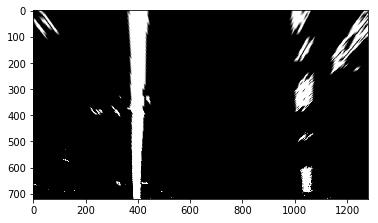

In [170]:
white_output = 'white.mp4'
clip1 = VideoFileClip("../CarND-Advanced-Lane-Lines/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [171]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(white_output))

TypeError: expected x and y to have same length

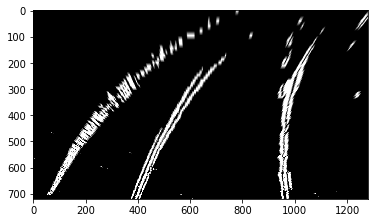

In [156]:
white_output = 'white1.mp4'
clip1 = VideoFileClip("../CarND-Advanced-Lane-Lines/challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [146]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(white_output))